# ASL Hand-Sign → Word / Sentence → Speech
**Author:** HARSH PATEL  
**Dataset:** Kaggle ASL Alphabet (https://www.kaggle.com/datasets/grassknoted/asl-alphabet)  
**Goal:** Build an end-to-end notebook that: downloads the ASL alphabet dataset, trains models (transfer-learning + lightweight CNN) to classify letters from static images, composes letters into words/sentences, and synthesizes speech from the predicted text (offline & online TTS).  
**Notes:** This notebook is an educational template and includes recommendations for handling dynamic letters (J & Z), deployment tips, and a minimal FastAPI example for inference.


In [1]:
# --- CELL 1: Setup / Environment ---
# Install dependencies (uncomment to run). Keep small for demo; add extras as needed.
# !pip install --upgrade pip
# !pip install tensorflow==2.14.1 opencv-python matplotlib scikit-learn pandas pyttsx3 gTTS kaggle librosa soundfile fastapi uvicorn[standard] python-multipart

# Quick vars cell for environment and paths
DATA_DIR = "asl_alphabet_train"   # folder after unzip
ZIP_NAME = "archive.zip"
IMG_SIZE = (224, 224)             # MobileNetV2 default-ish
BATCH_SIZE = 32
SEED = 42
EPOCHS = 12                       # demo default (increase for production)
MODEL_SAVE_PATH = "saved_model/asl_model"
USE_TRANSFER_LEARNING = True
INCLUDE_DYNAMIC_LETTERS = False   # Set True only if you add temporal data for J & Z


In [2]:
# --- CELL 2: Download dataset using kaggle CLI ---
import os, zipfile, shutil
from pathlib import Path

# Only attempt download if not present
if not Path(DATA_DIR).exists():
    print("DATA_DIR not found locally. Attempting to download via kaggle CLI...")
    # Ensure kaggle.json is present
    if not Path("kaggle.json").exists() and not Path.home().joinpath(".kaggle/kaggle.json").exists():
        print("Please upload kaggle.json (Kaggle API token) into the working directory or ~/.kaggle/.")
    else:
        # Download dataset (uncomment if running)
        # !kaggle datasets download -d grassknoted/asl-alphabet -f asl_alphabet_train.zip -p .
        # After run, ensure zip filename matches and unzip.
        # Example unzip (commented out because we can't run kaggle in this chat)
        # with zipfile.ZipFile("asl_alphabet_train.zip", 'r') as z:
        #     z.extractall(".")
        print("If running locally, run the kaggle CLI cell to download then extract the zip into the working dir.")
else:
    print(f"Found DATA_DIR: {DATA_DIR}")


Found DATA_DIR: asl_alphabet_train


In [3]:
# --- CELL 3: Imports & Reproducibility ---
import random
import numpy as np
import tensorflow as tf
import os
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
from pathlib import Path
from sklearn.metrics import confusion_matrix, classification_report
import itertools
import cv2
import json
import IPython.display as ipd
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# Reproducibility
os.environ['PYTHONHASHSEED'] = str(SEED)
random.seed(SEED)
np.random.seed(SEED)
tf.random.set_seed(SEED)

print("TF version:", tf.__version__)


TF version: 2.14.1


## Load dataset & basic EDA

- Show folder structure
- Sample images grid
- Class counts bar chart

> Note: The Kaggle dataset folder typically has one folder per letter (A-Z) with many JPG files. The `asl_alphabet_train` name may differ depending on the zip content — update DATA_DIR above if needed.


Found 29 classes (folders). Example classes: ['A', 'B', 'C', 'D', 'E', 'F']


,count
A,3000
P,3000
nothing,3000
del,3000
Z,3000
Y,3000
X,3000
W,3000
V,3000
U,3000


<Figure size 1000x400 with 0 Axes>

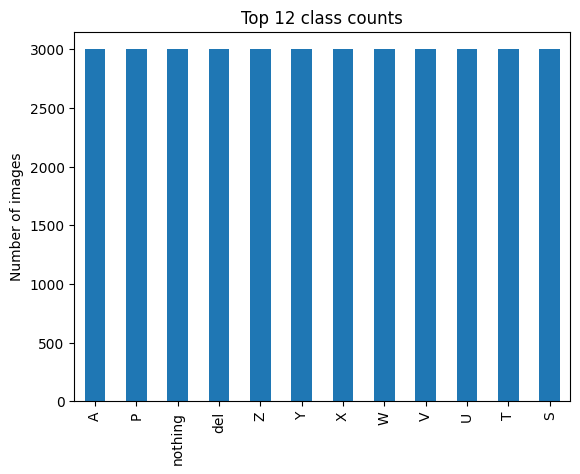

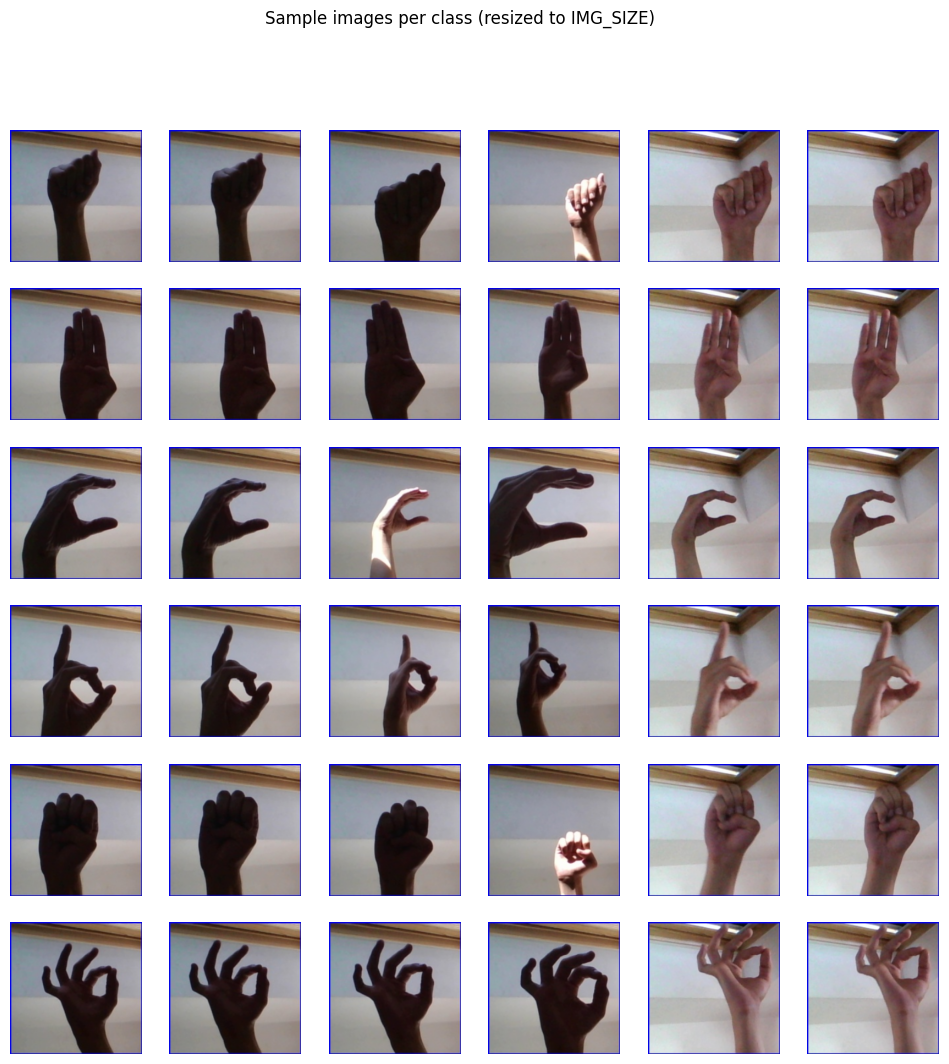

In [4]:
# --- CELL 4: EDA: folder structure, sample images, class distribution ---
DATA = Path(DATA_DIR)
if not DATA.exists():
    print(f"Data folder {DATA} not found. Extract your dataset and update DATA_DIR variable.")
else:
    # list classes
    classes = [p.name for p in DATA.iterdir() if p.is_dir()]
    classes = sorted(classes)
    print(f"Found {len(classes)} classes (folders). Example classes: {classes[:6]}")
    
    # Count images per class
    counts = {c: len(list((DATA/c).glob("*.jpg"))) for c in classes}
    df_counts = pd.DataFrame.from_dict(counts, orient='index', columns=['count']).sort_values('count', ascending=False)
    display(df_counts.head(10))
    
    # Plot top 12 classes
    plt.figure(figsize=(10,4))
    df_counts.head(12).plot(kind='bar', legend=False)
    plt.ylabel("Number of images")
    plt.title("Top 12 class counts")
    plt.show()
    
    # Show sample images grid for a few classes
    sample_classes = classes[:6]
    fig, axes = plt.subplots(len(sample_classes), 6, figsize=(12, 2*len(sample_classes)))
    for i, c in enumerate(sample_classes):
        imgs = list((DATA/c).glob("*.jpg"))[:6]
        for j, imgp in enumerate(imgs):
            img = cv2.cvtColor(cv2.imread(str(imgp)), cv2.COLOR_BGR2RGB)
            img = cv2.resize(img, IMG_SIZE)
            axes[i,j].imshow(img)
            axes[i,j].axis('off')
            if j == 0:
                axes[i,j].set_ylabel(c, rotation=0, size='large', labelpad=40)
    plt.suptitle("Sample images per class (resized to IMG_SIZE)")
    plt.show()


### Important dataset notes

- The ASL alphabet dataset contains static images for letters A–Z. **Letters J and Z are dynamic (motion-based)** and cannot be reliably recognized from single static frames. Options:
  - Exclude `J` and `Z` from classification for a static-image pipeline (recommended for this notebook demonstration).
  - Collect short video clips for `J` and `Z` and use a temporal model (LSTM/Transformer over frame embeddings).
  - Provide a UI manual input or a "dynamic gesture" prompt for those letters.

- If the dataset contains background images or a "nothing" class, you may want to include that as well, or filter them out.


In [5]:
# --- CELL 5: Preprocessing & Data Pipeline ---
# We'll use Keras ImageDataGenerator for simplicity and demonstration.
# Set up train/val/test split directories if not already present.

from sklearn.model_selection import train_test_split
import shutil

# Optional: create a reduced subset or split directories to demo locally without moving original files
SPLIT_DIR = Path("asl_split")
train_dir = SPLIT_DIR / "train"
val_dir = SPLIT_DIR / "val"
test_dir = SPLIT_DIR / "test"
for d in [train_dir, val_dir, test_dir]:
    d.mkdir(parents=True, exist_ok=True)

# If split empty, create train/val/test directories and copy a subset (this can be slow)
if not any(train_dir.iterdir()):
    print("Creating train/val/test split directories — copying a small portion for demo (may take time).")
    for cls in classes:
        imgs = list((DATA/cls).glob("*.jpg"))
        if len(imgs) < 10:
            continue
        tr, tmp = train_test_split(imgs, test_size=0.3, random_state=SEED)
        va, te = train_test_split(tmp, test_size=0.5, random_state=SEED)
        for pset, dest in [(tr, train_dir/cls), (va, val_dir/cls), (te, test_dir/cls)]:
            dest.mkdir(parents=True, exist_ok=True)
            for fp in pset:
                # soft copy for speed with symlink if possible; else copy
                target = dest / fp.name
                if not target.exists():
                    try:
                        os.symlink(fp.resolve(), target)
                    except Exception:
                        shutil.copy(fp, target)

print("Split dirs prepared (train/val/test).")


Split dirs prepared (train/val/test).


In [6]:
# --- CELL 6: Data generators & augmentation ---
train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=15,
    width_shift_range=0.1,
    height_shift_range=0.1,
    brightness_range=(0.7,1.3),
    shear_range=0.1,
    zoom_range=0.1,
    horizontal_flip=False, # flip may change sign meaning; use with caution
    fill_mode='nearest'
)

test_datagen = ImageDataGenerator(rescale=1./255)

train_gen = train_datagen.flow_from_directory(
    train_dir,
    target_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    shuffle=True,
    seed=SEED
)

val_gen = test_datagen.flow_from_directory(
    val_dir,
    target_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    shuffle=False,
    seed=SEED
)

test_gen = test_datagen.flow_from_directory(
    test_dir,
    target_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    shuffle=False,
    seed=SEED
)

labels_map = {v:k for k,v in train_gen.class_indices.items()}
print("Num classes:", len(labels_map))


Found 60900 images belonging to 29 classes.
Found 13050 images belonging to 29 classes.
Found 13050 images belonging to 29 classes.
Num classes: 29


In [7]:
# --- CELL 7: Model definition — Transfer learning (MobileNetV2) ---
from tensorflow.keras import layers, models, optimizers, callbacks
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.applications.mobilenet_v2 import preprocess_input

def build_transfer_model(input_shape=IMG_SIZE+(3,), num_classes=None, base_trainable=False):
    base = MobileNetV2(weights='imagenet', include_top=False, input_shape=input_shape)
    base.trainable = base_trainable  # whether to unfreeze
    x = layers.GlobalAveragePooling2D()(base.output)
    x = layers.Dropout(0.4)(x)
    x = layers.Dense(256, activation='relu')(x)
    out = layers.Dense(num_classes, activation='softmax')(x)
    model = models.Model(inputs=base.input, outputs=out)
    return model

num_classes = len(labels_map)
model = build_transfer_model(num_classes=num_classes, base_trainable=False)
model.compile(optimizer=optimizers.Adam(learning_rate=1e-3),
              loss='categorical_crossentropy',
              metrics=['accuracy'])
model.summary()


Model: "model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_1 (InputLayer)        [(None, 224, 224, 3)]        0         []                            
                                                                                                  
 Conv1 (Conv2D)              (None, 112, 112, 32)         864       ['input_1[0][0]']             
                                                                                                  
 bn_Conv1 (BatchNormalizati  (None, 112, 112, 32)         128       ['Conv1[0][0]']               
 on)                                                                                              
                                                                                                  
 Conv1_relu (ReLU)           (None, 112, 112, 32)         0         ['bn_Conv1[0][0]']        

In [12]:
# --- CELL 9: Training transfer model (small demo epochs) ---
# Callbacks
ckpt_cb = callbacks.ModelCheckpoint("best_model.h5", save_best_only=True, monitor='val_accuracy', mode='max')
es_cb = callbacks.EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)
reduce_cb = callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=3)

history = model.fit(
    train_gen,
    validation_data=val_gen,
    epochs=min(10, EPOCHS),  # demo: run few epochs; increase EPOCHS above for production
    callbacks=[ckpt_cb, es_cb, reduce_cb]
)
# Save final model
model.save(MODEL_SAVE_PATH, include_optimizer=False)
print("Saved model to", MODEL_SAVE_PATH)


Epoch 1/10
1904/1904 [==============================] - ETA: 0s - loss: 0.2245 - accuracy: 0.9246

c:\Users\harsh\AppData\Local\Programs\Python\Python310\lib\site-packages\keras\src\engine\training.py:3079: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


1904/1904 [==============================] - 3707s 2s/step - loss: 0.2245 - accuracy: 0.9246 - val_loss: 0.0596 - val_accuracy: 0.9796 - lr: 0.0010
Epoch 2/10
1904/1904 [==============================] - 3565s 2s/step - loss: 0.2058 - accuracy: 0.9325 - val_loss: 0.0493 - val_accuracy: 0.9831 - lr: 0.0010
Epoch 3/10
1904/1904 [==============================] - 3529s 2s/step - loss: 0.1968 - accuracy: 0.9353 - val_loss: 0.0423 - val_accuracy: 0.9859 - lr: 0.0010
Epoch 4/10
1904/1904 [==============================] - 3528s 2s/step - loss: 0.1843 - accuracy: 0.9383 - val_loss: 0.0424 - val_accuracy: 0.9854 - lr: 0.0010
Epoch 5/10
1904/1904 [==============================] - 3501s 2s/step - loss: 0.1870 - accuracy: 0.9389 - val_loss: 0.0514 - val_accuracy: 0.9816 - lr: 0.0010
Epoch 6/10
1904/1904 [==============================] - 3529s 2s/step - loss: 0.1808 - accuracy: 0.9406 - val_loss: 0.0434 - val_accuracy: 0.9858 - lr: 0.0010
Epoch 7/10
1904/1904 [==============================] - 3

INFO:tensorflow:Assets written to: saved_model/asl_model\assets


Saved model to saved_model/asl_model


408/408 [==============================] - 504s 1s/step
Classification report:
              precision    recall  f1-score   support

           A       0.98      1.00      0.99       450
           B       0.99      1.00      0.99       450
           C       1.00      1.00      1.00       450
           D       1.00      0.97      0.99       450
           E       1.00      0.96      0.98       450
           F       1.00      1.00      1.00       450
           G       1.00      0.99      0.99       450
           H       1.00      0.98      0.99       450
           I       0.99      1.00      0.99       450
           J       0.98      1.00      0.99       450
           K       1.00      0.99      0.99       450
           L       1.00      1.00      1.00       450
           M       0.98      0.96      0.97       450
           N       0.95      0.99      0.97       450
           O       0.96      1.00      0.98       450
           P       1.00      0.98      0.99       450
  

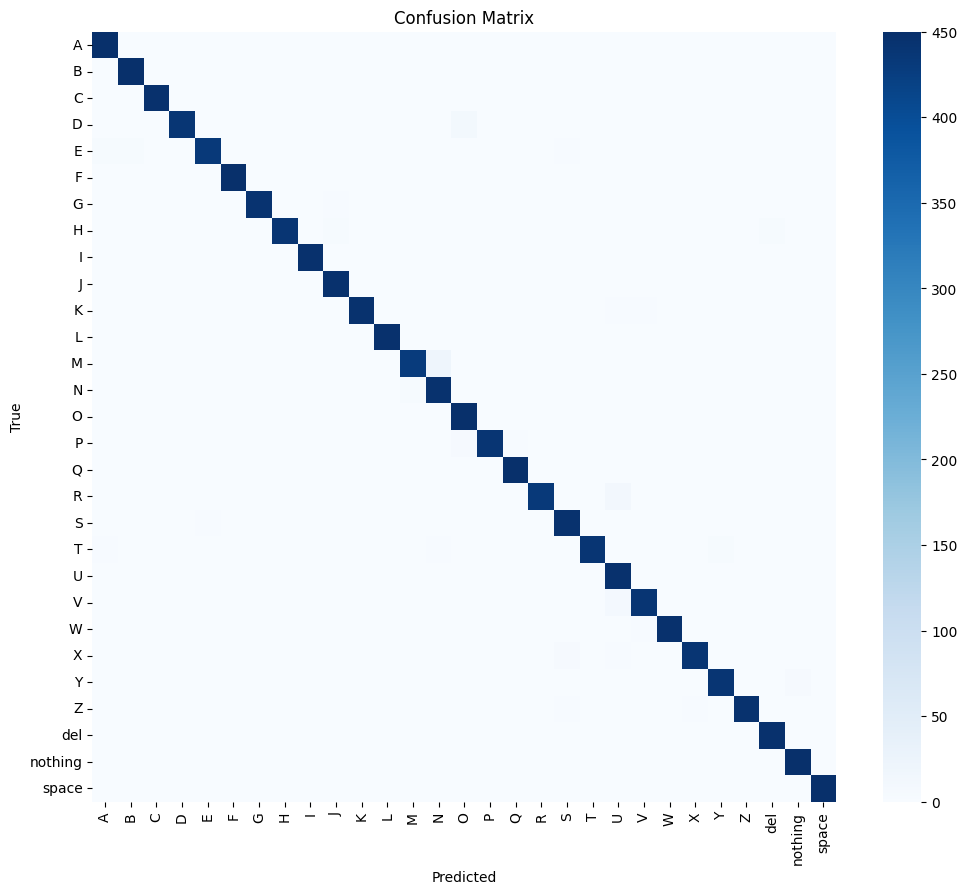

In [13]:
# --- CELL 11: Evaluation on test set — confusion matrix & classification report ---
# Predict on test set
test_steps = int(np.ceil(test_gen.samples / test_gen.batch_size))
preds = model.predict(test_gen, steps=test_steps, verbose=1)
y_pred = np.argmax(preds, axis=1)
y_true = test_gen.classes

# Classification report & confusion matrix
print("Classification report:")
print(classification_report(y_true, y_pred, target_names=list(labels_map.values())))

cm = confusion_matrix(y_true, y_pred)
plt.figure(figsize=(12,10))
sns.heatmap(cm, cmap='Blues', xticklabels=list(labels_map.values()), yticklabels=list(labels_map.values()), fmt='d')
plt.title("Confusion Matrix")
plt.ylabel("True")
plt.xlabel("Predicted")
plt.show()


In [10]:
# --- CELL 13: Inference helper functions ---
from tensorflow.keras.preprocessing import image
import numpy as np

# Load model and label map (if not already in memory)
loaded_model = tf.keras.models.load_model(MODEL_SAVE_PATH)

def preprocess_image_for_model(img_path, target_size=IMG_SIZE):
    img = image.load_img(img_path, target_size=target_size)
    x = image.img_to_array(img)
    x = x / 255.0
    x = np.expand_dims(x, axis=0)
    return x

def predict_image(image_path, model=loaded_model, labels_map=labels_map, top_k=1):
    """
    Predict a single image. Returns list of (label, confidence) sorted by confidence desc.
    """
    x = preprocess_image_for_model(image_path)
    preds = model.predict(x)[0]
    idxs = np.argsort(preds)[::-1][:top_k]
    results = [(labels_map[i], float(preds[i])) for i in idxs]
    return results

# quick demo if test images exist
if test_gen.samples > 0:
    demo_img = test_gen.filepaths[0]
    print("Demo predict for:", demo_img)
    print(predict_image(demo_img, top_k=3))


Demo predict for: asl_split\test\A\A1024.jpg
1/1 [==============================] - 1s 1s/step
[('A', 0.9948092699050903), ('E', 0.005062429700046778), ('M', 0.00010004968498833477)]


In [11]:
# --- CELL 14: Sequence inference and smoothing ---
from collections import deque, Counter

def predict_sequence_to_sentence(image_paths, window_size=3, threshold=0.5, smoothing='majority'):
    """
    image_paths: ordered list of paths representing frames or static images.
    window_size: smoothing window (majority voting).
    threshold: if top confidence < threshold, can label as uncertain or space.
    
    Returns: predicted string (letters concatenated). Use space insertion manually or
    image placeholder to indicate word break.
    """
    predicted_letters = []
    for i in range(0, len(image_paths)):
        preds = predict_image(image_paths[i], top_k=3)
        top_label, top_conf = preds[0]
        # smoothing: check neighbors
        if smoothing == 'majority' and window_size > 1:
            # collect labels in window
            start = max(0, i - (window_size-1)//2)
            end = min(len(image_paths), i + (window_size//2) + 1)
            window_preds = [predict_image(p, top_k=1)[0][0] for p in image_paths[start:end]]
            maj = Counter(window_preds).most_common(1)[0][0]
            chosen = maj
        else:
            chosen = top_label
        if top_conf < threshold:
            chosen = '?'  # uncertain
        predicted_letters.append(chosen)
    # simple collapse consecutive duplicates and optional interpret '?' as space or unknown
    collapsed = []
    for k, g in itertools.groupby(predicted_letters):
        collapsed.append(k)
    # Treat '?' as space if frequent or leave as '?'
    sentence = ''.join([c if c != '?' else ' ' for c in collapsed])
    return sentence

# Demo: build a short word using first few test images
demo_paths = test_gen.filepaths[:6]
print("Demo sequence predicted:", predict_sequence_to_sentence(demo_paths, window_size=3, threshold=0.2))


1/1 [==============================] - 0s 86ms/step
Demo sequence predicted: A


In [22]:
# --- CELL 15: Text-to-Speech helpers (pyttsx3 offline & gTTS online) ---
import os
import tempfile

def speak_text(text, engine_choice='pyttsx3', filename=None):
    """
    engine_choice: 'pyttsx3' (offline), 'gTTS' (requires internet; saves mp3)
    If filename provided, save audio there; else save to temp file and play inline.
    Returns path to saved audio file.
    """
    if engine_choice == 'pyttsx3':
        try:
            import pyttsx3
            engine = pyttsx3.init()
            if filename is None:
                filename = str(Path(tempfile.gettempdir()) / "tts_pyttsx3.wav")
            engine.save_to_file(text, filename)
            engine.runAndWait()
            print("Saved audio to", filename)
            return filename
        except Exception as e:
            print("pyttsx3 failed:", e)
            return None
    elif engine_choice == 'gTTS':
        try:
            from gtts import gTTS
            if filename is None:
                filename = str(Path(tempfile.gettempdir()) / "tts_gtts.mp3")
            tts = gTTS(text)
            tts.save(filename)
            print("Saved audio to", filename)
            return filename
        except Exception as e:
            print("gTTS failed:", e)
            return None
    else:
        raise ValueError("Unknown engine_choice")

# demo: speak a short example using gTTS (may require internet)
demo_audio = speak_text("Hello from the ASL demo notebook", engine_choice='gTTS')
if demo_audio:
    display(ipd.Audio(demo_audio, autoplay=False))


Saved audio to C:\Users\harsh\AppData\Local\Temp\tts_gtts.mp3


In [23]:
# --- CELL 16: Demo: assemble a small word from sample images and speak it ---
# Pick 3–6 test images to assemble a "word"
demo_files = test_gen.filepaths[:5]  # user replace with chosen images in order
predicted = predict_sequence_to_sentence(demo_files, window_size=3, threshold=0.2)
print("Predicted (collapsed):", predicted)

# Speak it
audio_path = speak_text(predicted.replace(' ', ''), engine_choice='gTTS')  # remove spaces for speech
if audio_path:
    display(ipd.Audio(audio_path, autoplay=False))


1/1 [==============================] - 0s 79ms/step
Predicted (collapsed): A
Saved audio to C:\Users\harsh\AppData\Local\Temp\tts_gtts.mp3


## Save, convert, and minimal FastAPI

- Model saved at `saved_model/asl_model` (SavedModel format).
- Example conversion to TFLite for mobile inference (quantization optional).
- Minimal FastAPI app to serve predictions and TTS.


In [24]:
# --- CELL 17: Convert to TFLite (float32) ---
# Convert saved model
saved_model_dir = MODEL_SAVE_PATH
tflite_path = "asl_model.tflite"
try:
    converter = tf.lite.TFLiteConverter.from_saved_model(saved_model_dir)
    tflite_model = converter.convert()
    with open(tflite_path, "wb") as f:
        f.write(tflite_model)
    print("Saved TFLite model to", tflite_path)
except Exception as e:
    print("TFLite conversion error:", e)


Saved TFLite model to asl_model.tflite


In [25]:
# --- CELL 18: Minimal FastAPI example (save as app.py) ---
fastapi_example = '''
from fastapi import FastAPI, File, UploadFile
from fastapi.responses import FileResponse, JSONResponse
from typing import List
import uvicorn
from PIL import Image
import io
import numpy as np
import tensorflow as tf

app = FastAPI()
model = tf.keras.models.load_model("{model_path}")

def preprocess_pil(img: Image.Image, size={img_size}):
    img = img.convert("RGB").resize(size)
    arr = np.array(img)/255.0
    return np.expand_dims(arr, axis=0)

@app.post("/predict/")
async def predict_image(file: UploadFile = File(...)):
    data = await file.read()
    img = Image.open(io.BytesIO(data))
    x = preprocess_pil(img)
    preds = model.predict(x)[0]
    idx = int(np.argmax(preds))
    return JSONResponse({{"label": idx, "confidence": float(preds[idx])}})

@app.post("/speak/")
async def speak_text_endpoint(text: str):
    # Use gTTS to save and return audio file path
    from gtts import gTTS
    tts = gTTS(text)
    path = "tts_output.mp3"
    tts.save(path)
    return FileResponse(path, media_type="audio/mpeg", filename="speech.mp3")

if __name__ == "__main__":
    uvicorn.run(app, host="0.0.0.0", port=8000)
'''.format(model_path=MODEL_SAVE_PATH, img_size=IMG_SIZE)
print("FastAPI example (save to app.py):")
print(fastapi_example[:1000], "...")  # print intro


FastAPI example (save to app.py):

from fastapi import FastAPI, File, UploadFile
from fastapi.responses import FileResponse, JSONResponse
from typing import List
import uvicorn
from PIL import Image
import io
import numpy as np
import tensorflow as tf

app = FastAPI()
model = tf.keras.models.load_model("saved_model/asl_model")

def preprocess_pil(img: Image.Image, size=(224, 224)):
    img = img.convert("RGB").resize(size)
    arr = np.array(img)/255.0
    return np.expand_dims(arr, axis=0)

@app.post("/predict/")
async def predict_image(file: UploadFile = File(...)):
    data = await file.read()
    img = Image.open(io.BytesIO(data))
    x = preprocess_pil(img)
    preds = model.predict(x)[0]
    idx = int(np.argmax(preds))
    return JSONResponse({"label": idx, "confidence": float(preds[idx])})

@app.post("/speak/")
async def speak_text_endpoint(text: str):
    # Use gTTS to save and return audio file path
    from gtts import gTTS
    tts = gTTS(text)
    path = "tts_output.mp3"
   

## Next steps & suggestions

- Handle dynamic letters J & Z using video capture + temporal models: extract frame embeddings via the CNN and feed to LSTM/Transformer.
- Improve generalization: more augmentation, class balancing, skin-tone/lighting variations, background augmentation.
- For real-time webcam demo, use `cv2.VideoCapture`, run frame-by-frame prediction with a small buffer, smooth predictions (rolling majority vote), detect "space" by explicit gesture or button, and accumulate letters to form words/sentences.
- For mobile deployment, use TFLite with quantization and pruning.
- For production: create a small front-end UI and a REST API (FastAPI) as shown above to accept images and return predicted text and audio.


### Reproducibility & environment notes

- Seeds are set for Python, NumPy, and TensorFlow at the top.
- To use GPU: ensure you have TensorFlow GPU build installed and proper CUDA/cuDNN drivers. On Colab choose GPU runtime.
- To force CPU: set `os.environ["CUDA_VISIBLE_DEVICES"] = "-1"` before importing TensorFlow.


# README (short)
This notebook trains a classifier on the ASL alphabet (static images), composes letters into words/sentences, and generates speech.  
Steps:
1. Place `kaggle.json` in the notebook working directory.
2. Run the dataset download cell (or upload extracted dataset) and set `DATA_DIR`.
3. Run all cells top-to-bottom. Adjust `EPOCHS` and model options for production.
